# Project: Handwritten Digits Recognition Web App

# Table of Contents
* [Introduction](#introduction)
* [Data Preprocessing](#data_preprocessing)
    1. Missing Values Check
    2. MaxAbs Scaling
    3. Adjusting Shape And Dimensions
    4. Class Imbalance Check
    5. OneHot Encoding
    6. Data augmentation
* [LeNet-5](#LeNet-5)
    * Structuring
    * Training
    * Evalution
    * Saving
* [Modified LeNet-5](#LeNet-5)
    * Structuring
    * Training
    * Evalution
    * Saving
* [Conclusions](#conclusions)

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,classification_report
from sklearn.preprocessing import maxabs_scale

In [3]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets,layers, Sequential ,callbacks,metrics,losses,optimizers

## Used Libraries

In [11]:
from sklearn import __version__ as skv
from matplotlib import __version__ as pltv
from numpy import __version__ as npv
from seaborn import __version__ as snsv
from tensorflow.keras import __version__ as ksv
from flask import __version__ as fkv
from cv2 import __version__ as cvv

print(f'{"Numpy":15} {npv}')
print(f'{"Matplotlib":15} {pltv}')
print(f'{"Seaborn":15} {snsv}')
print(f'{"Scikit-Learn":15} {skv}')
print(f'{"Keras":15} {ksv}')
print(f'{"Flask":15} {fkv}')
print(f'{"OpenCV":15} {cvv}')


Numpy           1.19.5
Matplotlib      3.4.2
Seaborn         0.11.1
Scikit-Learn    0.24.2
Keras           2.5.0
Flask           2.0.1
OpenCV          4.5.3


# Data Preprocessing

In [4]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()


In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
y_train.shape

(60000,)

In [7]:
x_test.shape

(10000, 28, 28)

In [8]:
y_test.shape

(10000,)

# Missing values Check

In [9]:
np.isnan(x_train).any()

False

In [10]:
np.isnan(y_train).any()

False

In [11]:
np.isnan(x_test).any()

False

In [12]:
np.isnan(y_test).any()

False

# MaxAbs Scaling

In [13]:
x_train[0].max()

255

In [14]:
x_train_scaled = np.array([maxabs_scale(x) for x in x_train])
x_test_scaled = np.array([maxabs_scale(x) for x in x_test])

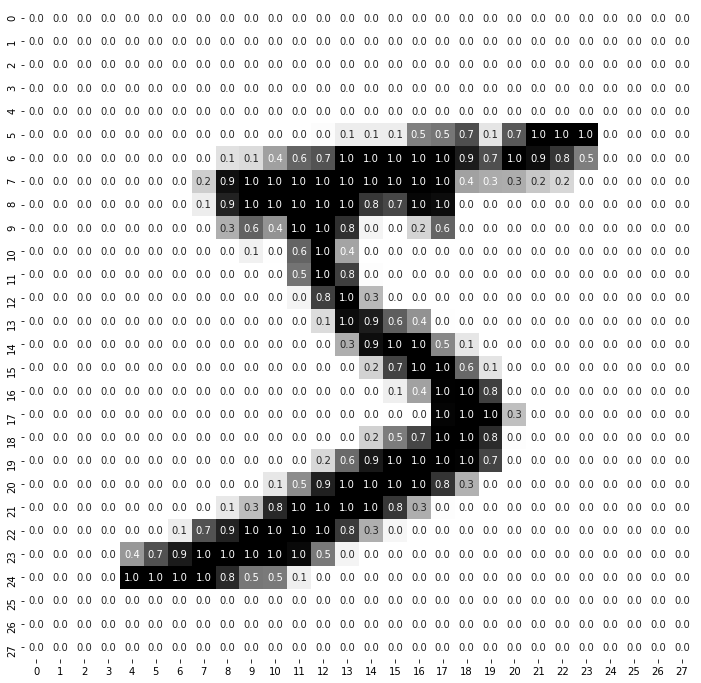

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(x_train_scaled[0],annot=True,cbar=False,cmap='gray_r',fmt='.1f')
plt.show()

# Adjusting Shape And Dimensions

In [16]:
x_train_scaled = np.expand_dims(x_train_scaled,axis=-1)
x_test_scaled = np.expand_dims(x_test_scaled,axis=-1)

In [17]:
x_train_scaled = np.pad(x_train_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test_scaled = np.pad(x_test_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [18]:
x_train_scaled.shape

(60000, 32, 32, 1)

In [19]:
x_test_scaled.shape

(10000, 32, 32, 1)

# OneHot Encoding

In [20]:
y_train_OneHot = to_categorical(y_train, num_classes = 10)
y_test_OneHot = to_categorical(y_test, num_classes = 10)

In [21]:
y_train_OneHot.shape

(60000, 10)

In [22]:
y_test_OneHot.shape

(10000, 10)

# Class Imbalance Check

 where the classes are not represented equally

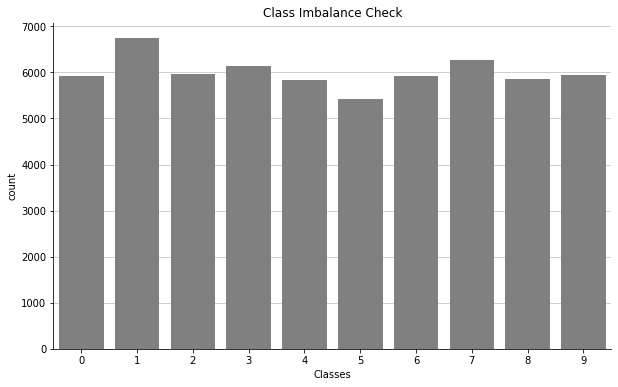

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_train,color='#808080')
plt.title('Class Imbalance Check')
plt.xlabel('Classes')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)
plt.show()

# Data augmentation

In [24]:
datagen = ImageDataGenerator(rotation_range=10,zoom_range = 0.1,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(x_train_scaled)       

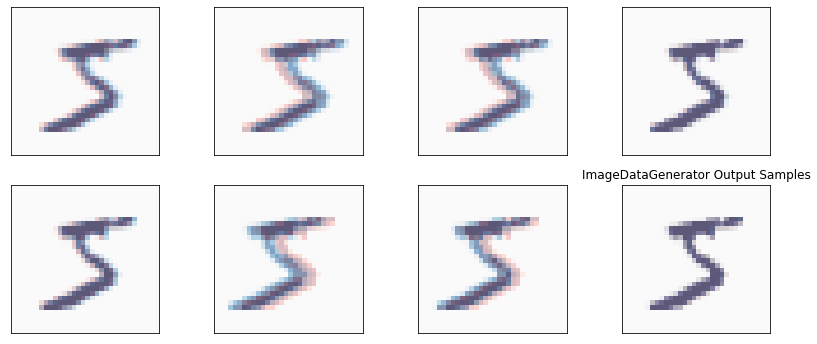

In [40]:
datagen = ImageDataGenerator(width_shift_range=0.1)
aug_iter = datagen.flow(np.expand_dims(x_train_scaled[0],axis=0), batch_size=1)
fig,ax = plt.subplots(2,4,figsize=(14,6))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(x_train_scaled[0],cmap='Reds',alpha=0.5)
        image = aug_iter.next()[0].astype(float)
        ax[i,j].imshow(image,cmap='Blues',alpha=0.5)
        ax[i,j].yaxis.set_visible(False)
        ax[i,j].xaxis.set_visible(False)
plt.show()

In [26]:
xknczkxc

NameError: name 'xknczkxc' is not defined

# Modeling

# LeNet-5

# Structuring

In [ ]:
model_1 = Sequential()

model_1.add(layers.Conv2D(filters = 6, kernel_size = (5,5),padding='valid', activation = 'relu', input_shape = (32,32,1)))
model_1.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model_1.add(layers.Conv2D(filters = 16, kernel_size = (5,5),padding='valid', activation = 'relu'))
model_1.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(units = 120, activation = 'relu'))
model_1.add(layers.Dense(units = 84, activation = 'relu'))
model_1.add(layers.Dense(units = 10, activation = 'softmax'))

# Training

In [ ]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,min_lr=0.00001)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_1.fit(datagen.flow(x_train_scaled,y_train_OneHot,batch_size=100,), 
                    epochs = 30, 
                    validation_data = (x_test_scaled,y_test_OneHot),
                    callbacks=[learning_rate_reduction],
                    verbose = 1)

Epoch 1/30
600/600 [==============================] - 46s 69ms/step - loss: 0.3368 - accuracy: 0.8976 - val_loss: 0.0825 - val_accuracy: 0.9721
Epoch 2/30
600/600 [==============================] - 39s 65ms/step - loss: 0.0945 - accuracy: 0.9708 - val_loss: 0.0596 - val_accuracy: 0.9780
Epoch 3/30
600/600 [==============================] - 37s 61ms/step - loss: 0.0695 - accuracy: 0.9786 - val_loss: 0.0471 - val_accuracy: 0.9833
Epoch 4/30
600/600 [==============================] - 31s 52ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.0459 - val_accuracy: 0.9860
Epoch 5/30
600/600 [==============================] - 32s 53ms/step - loss: 0.0510 - accuracy: 0.9837 - val_loss: 0.0356 - val_accuracy: 0.9883
Epoch 6/30
600/600 [==============================] - 31s 52ms/step - loss: 0.0460 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.9868
Epoch 7/30
600/600 [==============================] - 32s 53ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0453 - val_accuracy:

# Evaluation

In [ ]:
y_pred = np.argmax(model_1.predict(x_test_scaled), axis=-1)

In [ ]:
print(f'{"accuracy":10} {(y_pred == y_test).mean():.4f}')
print(f'{"precision":10} {precision_score(y_test,y_pred,average="macro"):.4f}')
print(f'{"recall":10} {recall_score(y_test,y_pred,average="macro"):.4f}')

accuracy   0.9925
precision  0.9925
recall     0.9924


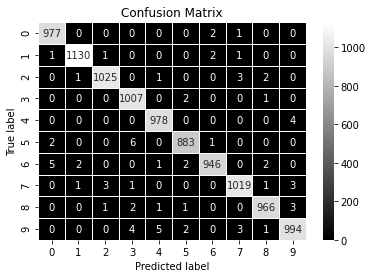

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt="d",linewidths=.5,cmap='gray')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

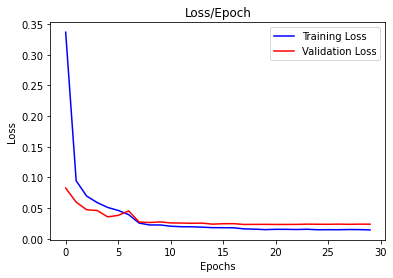

In [ ]:
plt.plot(history.epoch,history.history['loss'],color='blue',label='Training Loss')
plt.plot(history.epoch,history.history['val_loss'],color='red',label='Validation Loss')
plt.title('Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


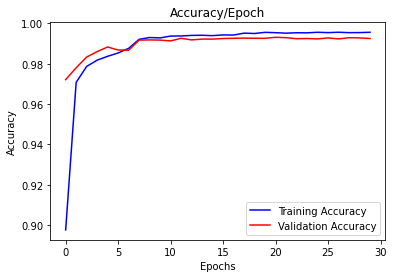

In [ ]:
plt.plot(history.epoch,history.history['accuracy'],color='blue',label='Training Accuracy')
plt.plot(history.epoch,history.history['val_accuracy'],color='red',label='Validation Accuracy')
plt.title('Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_18 (Dense)             (None, 84)               

In [ ]:
model_1.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

# Saving

In [ ]:
model_1.save("LeNet_5.h5")

# Modified LeNet-5

# Structuring

In [ ]:
from tensorflow.keras.regularizers import l2

model_2 = Sequential()

model_2.add(layers.Conv2D(filters = 6, kernel_size = (5,5),padding='valid', input_shape = (32,32,1),kernel_regularizer=l2(0.0005)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model_2.add(layers.Conv2D(filters = 16, kernel_size = (5,5),padding='valid',kernel_regularizer=l2(0.0005)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model_2.add(layers.Flatten())

model_2.add(layers.Dense(units = 250))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.25))

model_2.add(layers.Dense(units = 120))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.25))

model_2.add(layers.Dense(units = 84))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))


model_2.add(layers.Dense(units = 10, activation = 'softmax'))

https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f

https://keras.io/api/callbacks/reduce_lr_on_plateau/

#optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

#optimizer = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

#model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu',input_shape = (28,28,1)))

# Training

In [ ]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,min_lr=0.00001)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_2.fit(datagen.flow(x_train_scaled,y_train_OneHot,batch_size=100,), 
                    epochs = 30, 
                    validation_data = (x_test_scaled,y_test_OneHot),
                    callbacks=[learning_rate_reduction],
                    verbose = 1)

Epoch 1/30
600/600 [==============================] - 104s 81ms/step - loss: 0.3119 - accuracy: 0.9115 - val_loss: 0.0857 - val_accuracy: 0.9734
Epoch 2/30
600/600 [==============================] - 49s 80ms/step - loss: 0.1081 - accuracy: 0.9695 - val_loss: 0.0533 - val_accuracy: 0.9847
Epoch 3/30
600/600 [==============================] - 49s 81ms/step - loss: 0.0827 - accuracy: 0.9769 - val_loss: 0.0521 - val_accuracy: 0.9857
Epoch 4/30
600/600 [==============================] - 48s 80ms/step - loss: 0.0702 - accuracy: 0.9804 - val_loss: 0.0536 - val_accuracy: 0.9850
Epoch 5/30
600/600 [==============================] - 50s 83ms/step - loss: 0.0629 - accuracy: 0.9826 - val_loss: 0.0429 - val_accuracy: 0.9887
Epoch 6/30
600/600 [==============================] - 48s 80ms/step - loss: 0.0560 - accuracy: 0.9847 - val_loss: 0.0429 - val_accuracy: 0.9888
Epoch 7/30
600/600 [==============================] - 46s 76ms/step - loss: 0.0534 - accuracy: 0.9855 - val_loss: 0.0429 - val_accuracy

# Evaluation

In [ ]:
y_pred = np.argmax(model_2.predict(x_test_scaled), axis=-1)

In [ ]:
print(f'{"accuracy":10} {(y_pred == y_test).mean():.4f}')
print(f'{"precision":10} {precision_score(y_test,y_pred,average="macro"):.4f}')
print(f'{"recall":10} {recall_score(y_test,y_pred,average="macro"):.4f}')

accuracy   0.9939
precision  0.9939
recall     0.9939


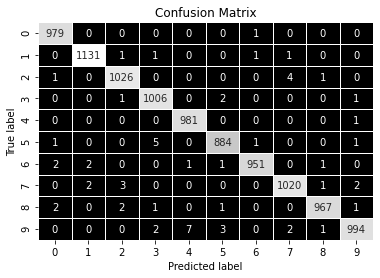

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt="d",linewidths=.5,cmap='gray')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

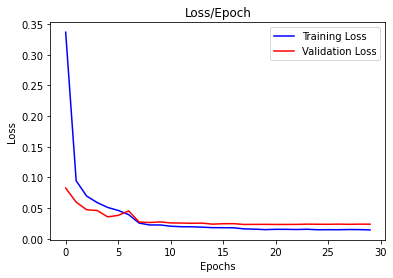

In [ ]:
plt.plot(history.epoch,history.history['loss'],color='blue',label='Training Loss')
plt.plot(history.epoch,history.history['val_loss'],color='red',label='Validation Loss')
plt.title('Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

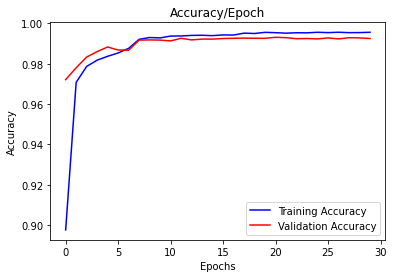

In [ ]:
plt.plot(history.epoch,history.history['accuracy'],color='blue',label='Training Accuracy')
plt.plot(history.epoch,history.history['val_accuracy'],color='red',label='Validation Accuracy')
plt.title('Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Saving

In [ ]:
model.save("modified_LeNet_5.h5")